### Environment Setup

In [1]:
import data_loader
import numpy as np
import os
import tensorflow as tf
import math
import timeit
import pandas as pd
import matplotlib.pyplot as plt
import sys
import updated_plots
%matplotlib inline
import tensorflow.python.keras.backend as K
import plotly.express as px
from sklearn.metrics import pairwise_distances

In [2]:
%load_ext autoreload
%autoreload 2

### Load Data

In [3]:
loader = data_loader.DataLoader("./data/UniRep1900_BareNucRepr.csv")
(x_train, x_val, x_test), (y_train, y_val, y_test) = loader.loadTrainValTest()
y_train = np.reshape(y_train, newshape = (len(y_train), 1))
y_val = np.reshape(y_val, newshape = (len(y_val), 1))
y_test = np.reshape(y_test, newshape = (len(y_test), 1))

x_train_repr = x_train
x_val_repr = x_val
x_test_repr = x_test
y_train_repr = y_train
y_val_repr = y_val
y_test_repr = y_test

print(len(y_train))
print(len(y_val))
print(len(y_test))
print(len(y_train)+len(y_val)+len(y_test))

2792
262
239
3293


In [4]:
loader = data_loader.DataLoader("./data/UniRep1900_BareTilingRepressors.csv")
(x_train, x_val, x_test), (y_train, y_val, y_test) = loader.loadTrainValTest()
y_train = np.reshape(y_train, newshape = (len(y_train), 1))
y_val = np.reshape(y_val, newshape = (len(y_val), 1))
y_test = np.reshape(y_test, newshape = (len(y_test), 1))

x_train_til = x_train
x_val_til = x_val
x_test_til = x_test
y_train_til = y_train
y_val_til = y_val
y_test_til = y_test

print(len(y_train))
print(len(y_val))
print(len(y_test))
print(len(y_train)+len(y_val)+len(y_test))

8613
790
1135
10538


In [5]:
print(np.std(x_train_til, axis = 0))
print(np.std(x_train_repr, axis = 0))

print(np.std(y_train_repr))
print(np.std(y_train_til))

print(np.mean(y_train_repr))
print(np.mean(y_train_til))

[0.00726615 0.05126093 0.02110841 ... 0.06486924 0.10247835 0.06979797]
[0.02733166 0.08283375 0.02488851 ... 0.10468469 0.12960086 0.0442049 ]
2.0609592592898025
0.6027209636864008
0.3241966690544412
0.25689806107047486


In [6]:
# Combine features
x_train_comb = np.append(x_train_repr, x_train_til, axis = 0)
x_val_comb = np.append(x_val_repr, x_val_til, axis = 0)
x_test_comb = np.append(x_test_repr, x_test_til, axis = 0)

# Combine labels
y_train_comb = np.append(y_train_repr, y_train_til, axis = 0)
y_val_comb = np.append(y_val_repr, y_val_til, axis = 0)
y_test_comb = np.append(y_test_repr, y_test_til, axis = 0)


# Define random permutation
train_ord = np.arange(len(x_train_comb))
np.random.shuffle(train_ord)

val_ord = np.arange(len(x_val_comb))
np.random.shuffle(val_ord)

test_ord = np.arange(len(x_test_comb))
np.random.shuffle(test_ord)


# Shuffle features and labels
x_train_comb = x_train_comb[train_ord,:]
x_val_comb = x_val_comb[val_ord,:]
x_test_comb = x_test_comb[test_ord,:]

y_train_comb = y_train_comb[train_ord]
y_val_comb = y_val_comb[val_ord]
y_test_comb = y_test_comb[test_ord]

print("Train Size (Repression, Tiling, Combined)")
print(len(x_train_repr))
print(len(x_train_til))
print(len(x_train_comb))

print("\nValidation Size (Repression, Tiling, Combined)")
print(len(x_val_repr))
print(len(x_val_til))
print(len(x_val_comb))

print("\nTest Size (Repression, Tiling, Combined)")
print(len(x_test_repr))
print(len(x_test_til))
print(len(x_test_comb))


Train Size (Repression, Tiling, Combined)
2792
8613
11405

Validation Size (Repression, Tiling, Combined)
262
790
1052

Test Size (Repression, Tiling, Combined)
239
1135
1374


## 1. Fully Connected Model (UniRep Features)

In [7]:
USE_GPU = True
device = "/device:GPU:0"

def modelTrain(model, lr, n_epoch, batch_size=128, verbose=1, data = "repr", earlystop_callback=None):
    if data == 'tiling':
        x_train, y_train, x_val, y_val = x_train_til, y_train_til, x_val_til, y_val_til
    elif data == 'repr':
        x_train, y_train, x_val, y_val = x_train_repr, y_train_repr, x_val_repr, y_val_repr
    elif data == 'comb':
        x_train, y_train, x_val, y_val = x_train_comb, y_train_comb, x_val_comb, y_val_comb
    else:
        print("Wrong data type")
        return

    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error', 
                  metrics=["mean_squared_error", "mean_absolute_error"])
    history = model.fit(x_train, y_train, epochs=n_epoch, validation_data=(x_val, y_val),
                        batch_size=batch_size, verbose=verbose, callbacks=earlystop_callback)
    return history.history, history.history.get("val_mean_squared_error")[-1]

            
def plot(out, data = "repr", model_type = "FC"):
    legend = {"tiling": "tiling data", "repr": "repression data", "comb": "tiling and repression data"}
    train_losses = out.get("mean_squared_error")
    train_mae = out.get("mean_absolute_error")
    print(out.keys()) # gives dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])
    val_losses = out.get("val_mean_squared_error")
    val_mae = out.get("val_mean_absolute_error")
    
    updated_plots.plotTrainCurve({"Training loss": train_losses, 
                                  "Validation loss": val_losses}, 
                                 y_label='MSE Loss', 
                                 title= model_type + ' loss curve trained on ' + legend[data], 
                                 show_title=True, 
                                 show=True, save=True)
    
    updated_plots.plotTrainCurve({"Training MAE": train_mae, 
                                  "Validation MAE": val_mae}, 
                                 y_label='MAE', 
                                 title= model_type + ' MAE curve trained on ' + legend[data], 
                                 show_title=True, 
                                 show=True, save=True)
    
    
def plotPred(model, data = "repr", model_type = "FC"):
    legend = {"tiling": "tiling data", "repr": "repression data", "comb": "tiling and repression data"}
    if data == 'tiling':
        x_train, y_train, x_val, y_val = x_train_til, y_train_til, x_val_til, y_val_til
    elif data == 'repr':
        x_train, y_train, x_val, y_val = x_train_repr, y_train_repr, x_val_repr, y_val_repr
    elif data == 'comb':
        x_train, y_train, x_val, y_val = x_train_comb, y_train_comb, x_val_comb, y_val_comb
    else:
        print("Wrong data type")
        return
    
    train_pred = model.predict(x_train)
    updated_plots.plotActualVsPred(y_train, train_pred, label="repression score", 
                                   title='Predicted vs. true scores for ' + model_type + ' model \non ' + legend[data],
                     show_title=True, show=True, save=True)
    
    val_pred = model.predict(x_val)
    updated_plots.plotActualVsPred(y_val, val_pred, label="repression score", 
                                   title='Predicted vs. true scores for ' + model_type + ' model \non ' + legend[data],
                     show_title=True, show=True, save=True)
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 900)               1710900   
_________________________________________________________________
dropout (Dropout)            (None, 900)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               270300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

Epoch 31/2000
22/22 [==============================] - 0s 7ms/step - loss: 7.3416 - mean_squared_error: 2.0063 - mean_absolute_error: 0.7541 - val_loss: 6.0628 - val_mean_squared_error: 0.7403 - val_mean_absolute_error: 0.5293
Epoch 32/2000
22/22 [==============================] - 0s 7ms/step - loss: 6.9431 - mean_squared_error: 1.6320 - mean_absolute_error: 0.7091 - val_loss: 6.0390 - val_mean_squared_error: 0.7407 - val_mean_absolute_error: 0.5375
Epoch 33/2000
22/22 [==============================] - 0s 7ms/step - loss: 7.0823 - mean_squared_error: 1.7954 - mean_absolute_error: 0.7233 - val_loss: 6.0085 - val_mean_squared_error: 0.7343 - val_mean_absolute_error: 0.5217
Epoch 34/2000
22/22 [==============================] - 0s 7ms/step - loss: 6.8974 - mean_squared_error: 1.6345 - mean_absolute_error: 0.7039 - val_loss: 5.9763 - val_mean_squared_error: 0.7261 - val_mean_absolute_error: 0.5231
Epoch 35/2000
22/22 [==============================] - 0s 7ms/step - loss: 6.9598 - mean_squ

22/22 [==============================] - 0s 7ms/step - loss: 5.3051 - mean_squared_error: 1.3713 - mean_absolute_error: 0.6390 - val_loss: 4.6039 - val_mean_squared_error: 0.6777 - val_mean_absolute_error: 0.5057
Epoch 104/2000
22/22 [==============================] - 0s 7ms/step - loss: 5.2530 - mean_squared_error: 1.3333 - mean_absolute_error: 0.6322 - val_loss: 4.5962 - val_mean_squared_error: 0.6840 - val_mean_absolute_error: 0.5114
Epoch 105/2000
22/22 [==============================] - 0s 7ms/step - loss: 5.3390 - mean_squared_error: 1.4333 - mean_absolute_error: 0.6464 - val_loss: 4.5841 - val_mean_squared_error: 0.6858 - val_mean_absolute_error: 0.4922
Epoch 106/2000
22/22 [==============================] - 0s 7ms/step - loss: 5.2175 - mean_squared_error: 1.3257 - mean_absolute_error: 0.6299 - val_loss: 4.5706 - val_mean_squared_error: 0.6862 - val_mean_absolute_error: 0.5198
Epoch 107/2000
22/22 [==============================] - 0s 7ms/step - loss: 5.3828 - mean_squared_error

Epoch 139/2000
22/22 [==============================] - 0s 7ms/step - loss: 4.7573 - mean_squared_error: 1.2694 - mean_absolute_error: 0.6036 - val_loss: 4.1723 - val_mean_squared_error: 0.6901 - val_mean_absolute_error: 0.5170
Epoch 140/2000
22/22 [==============================] - 0s 7ms/step - loss: 4.9496 - mean_squared_error: 1.4724 - mean_absolute_error: 0.6312 - val_loss: 4.1416 - val_mean_squared_error: 0.6701 - val_mean_absolute_error: 0.5046
Epoch 141/2000
22/22 [==============================] - 0s 7ms/step - loss: 4.9707 - mean_squared_error: 1.5044 - mean_absolute_error: 0.6243 - val_loss: 4.1584 - val_mean_squared_error: 0.6977 - val_mean_absolute_error: 0.5123
Epoch 142/2000
22/22 [==============================] - 0s 7ms/step - loss: 4.7173 - mean_squared_error: 1.2616 - mean_absolute_error: 0.6062 - val_loss: 4.0992 - val_mean_squared_error: 0.6491 - val_mean_absolute_error: 0.4784
Epoch 143/2000
22/22 [==============================] - 0s 7ms/step - loss: 4.7555 - mea

Epoch 175/2000
22/22 [==============================] - 0s 7ms/step - loss: 4.4954 - mean_squared_error: 1.3589 - mean_absolute_error: 0.5961 - val_loss: 3.7972 - val_mean_squared_error: 0.6652 - val_mean_absolute_error: 0.4980
Epoch 176/2000
22/22 [==============================] - 0s 7ms/step - loss: 4.2940 - mean_squared_error: 1.1662 - mean_absolute_error: 0.5684 - val_loss: 3.7753 - val_mean_squared_error: 0.6523 - val_mean_absolute_error: 0.4917
Epoch 177/2000
22/22 [==============================] - 0s 7ms/step - loss: 4.4417 - mean_squared_error: 1.3228 - mean_absolute_error: 0.5962 - val_loss: 3.7726 - val_mean_squared_error: 0.6582 - val_mean_absolute_error: 0.4869
Epoch 178/2000
22/22 [==============================] - 0s 7ms/step - loss: 4.3669 - mean_squared_error: 1.2565 - mean_absolute_error: 0.5844 - val_loss: 3.7760 - val_mean_squared_error: 0.6702 - val_mean_absolute_error: 0.5035
Epoch 179/2000
22/22 [==============================] - 0s 7ms/step - loss: 4.4586 - mea

Epoch 211/2000
22/22 [==============================] - 0s 7ms/step - loss: 4.0069 - mean_squared_error: 1.1591 - mean_absolute_error: 0.5492 - val_loss: 3.4952 - val_mean_squared_error: 0.6514 - val_mean_absolute_error: 0.5088
Epoch 212/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.9764 - mean_squared_error: 1.1361 - mean_absolute_error: 0.5500 - val_loss: 3.4809 - val_mean_squared_error: 0.6444 - val_mean_absolute_error: 0.4954
Epoch 213/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.9411 - mean_squared_error: 1.1079 - mean_absolute_error: 0.5433 - val_loss: 3.4751 - val_mean_squared_error: 0.6458 - val_mean_absolute_error: 0.4877
Epoch 214/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.9327 - mean_squared_error: 1.1069 - mean_absolute_error: 0.5394 - val_loss: 3.4477 - val_mean_squared_error: 0.6259 - val_mean_absolute_error: 0.4809
Epoch 215/2000
22/22 [==============================] - 0s 7ms/step - loss: 4.0047 - mea

Epoch 247/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.6863 - mean_squared_error: 1.0849 - mean_absolute_error: 0.5325 - val_loss: 3.2096 - val_mean_squared_error: 0.6116 - val_mean_absolute_error: 0.4597
Epoch 248/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.7170 - mean_squared_error: 1.1222 - mean_absolute_error: 0.5356 - val_loss: 3.2113 - val_mean_squared_error: 0.6201 - val_mean_absolute_error: 0.4819
Epoch 249/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.8076 - mean_squared_error: 1.2194 - mean_absolute_error: 0.5515 - val_loss: 3.2323 - val_mean_squared_error: 0.6475 - val_mean_absolute_error: 0.5060
Epoch 250/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.5586 - mean_squared_error: 0.9766 - mean_absolute_error: 0.5206 - val_loss: 3.1937 - val_mean_squared_error: 0.6148 - val_mean_absolute_error: 0.4711
Epoch 251/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.6695 - mea

Epoch 283/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.2973 - mean_squared_error: 0.9123 - mean_absolute_error: 0.4961 - val_loss: 2.9860 - val_mean_squared_error: 0.6040 - val_mean_absolute_error: 0.4742
Epoch 284/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.4319 - mean_squared_error: 1.0527 - mean_absolute_error: 0.5193 - val_loss: 2.9828 - val_mean_squared_error: 0.6067 - val_mean_absolute_error: 0.4765
Epoch 285/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.5459 - mean_squared_error: 1.1725 - mean_absolute_error: 0.5261 - val_loss: 2.9826 - val_mean_squared_error: 0.6122 - val_mean_absolute_error: 0.4797
Epoch 286/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.6188 - mean_squared_error: 1.2510 - mean_absolute_error: 0.5472 - val_loss: 2.9735 - val_mean_squared_error: 0.6085 - val_mean_absolute_error: 0.4810
Epoch 287/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.5671 - mea

Epoch 319/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.0597 - mean_squared_error: 0.8663 - mean_absolute_error: 0.4741 - val_loss: 2.8120 - val_mean_squared_error: 0.6213 - val_mean_absolute_error: 0.4802
Epoch 320/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.2911 - mean_squared_error: 1.1029 - mean_absolute_error: 0.5086 - val_loss: 2.8082 - val_mean_squared_error: 0.6227 - val_mean_absolute_error: 0.4865
Epoch 321/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.2021 - mean_squared_error: 1.0189 - mean_absolute_error: 0.5042 - val_loss: 2.7836 - val_mean_squared_error: 0.6028 - val_mean_absolute_error: 0.4557
Epoch 322/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.2529 - mean_squared_error: 1.0745 - mean_absolute_error: 0.4999 - val_loss: 2.7635 - val_mean_squared_error: 0.5877 - val_mean_absolute_error: 0.4485
Epoch 323/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.4961 - mea

Epoch 355/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.9950 - mean_squared_error: 0.9721 - mean_absolute_error: 0.4923 - val_loss: 2.6081 - val_mean_squared_error: 0.5875 - val_mean_absolute_error: 0.4564
Epoch 356/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.1062 - mean_squared_error: 1.0876 - mean_absolute_error: 0.5004 - val_loss: 2.6154 - val_mean_squared_error: 0.5992 - val_mean_absolute_error: 0.4624
Epoch 357/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.2092 - mean_squared_error: 1.1949 - mean_absolute_error: 0.5095 - val_loss: 2.6160 - val_mean_squared_error: 0.6040 - val_mean_absolute_error: 0.4613
Epoch 358/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.0789 - mean_squared_error: 1.0689 - mean_absolute_error: 0.4931 - val_loss: 2.6142 - val_mean_squared_error: 0.6065 - val_mean_absolute_error: 0.4660
Epoch 359/2000
22/22 [==============================] - 0s 7ms/step - loss: 3.0891 - mea

Epoch 391/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.9567 - mean_squared_error: 1.0828 - mean_absolute_error: 0.4966 - val_loss: 2.5010 - val_mean_squared_error: 0.6291 - val_mean_absolute_error: 0.4740
Epoch 392/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.9827 - mean_squared_error: 1.1122 - mean_absolute_error: 0.4984 - val_loss: 2.5012 - val_mean_squared_error: 0.6328 - val_mean_absolute_error: 0.4480
Epoch 393/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.9612 - mean_squared_error: 1.0947 - mean_absolute_error: 0.5067 - val_loss: 2.4770 - val_mean_squared_error: 0.6127 - val_mean_absolute_error: 0.4486
Epoch 394/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.9242 - mean_squared_error: 1.0616 - mean_absolute_error: 0.4884 - val_loss: 2.4687 - val_mean_squared_error: 0.6081 - val_mean_absolute_error: 0.4596
Epoch 395/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.9537 - mea

Epoch 427/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.7910 - mean_squared_error: 1.0487 - mean_absolute_error: 0.4776 - val_loss: 2.3629 - val_mean_squared_error: 0.6227 - val_mean_absolute_error: 0.4416
Epoch 428/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.8436 - mean_squared_error: 1.1047 - mean_absolute_error: 0.4939 - val_loss: 2.3401 - val_mean_squared_error: 0.6026 - val_mean_absolute_error: 0.4418
Epoch 429/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.7787 - mean_squared_error: 1.0430 - mean_absolute_error: 0.4874 - val_loss: 2.3486 - val_mean_squared_error: 0.6148 - val_mean_absolute_error: 0.4514
Epoch 430/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.8046 - mean_squared_error: 1.0725 - mean_absolute_error: 0.4938 - val_loss: 2.3936 - val_mean_squared_error: 0.6634 - val_mean_absolute_error: 0.4712
Epoch 431/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.6222 - mea

Epoch 463/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.6787 - mean_squared_error: 1.0538 - mean_absolute_error: 0.4797 - val_loss: 2.2567 - val_mean_squared_error: 0.6335 - val_mean_absolute_error: 0.4544
Epoch 464/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.6337 - mean_squared_error: 1.0117 - mean_absolute_error: 0.4735 - val_loss: 2.2559 - val_mean_squared_error: 0.6352 - val_mean_absolute_error: 0.4712
Epoch 465/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.5868 - mean_squared_error: 0.9676 - mean_absolute_error: 0.4671 - val_loss: 2.2233 - val_mean_squared_error: 0.6058 - val_mean_absolute_error: 0.4279
Epoch 466/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.6757 - mean_squared_error: 1.0598 - mean_absolute_error: 0.4813 - val_loss: 2.2465 - val_mean_squared_error: 0.6323 - val_mean_absolute_error: 0.4520
Epoch 467/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.6084 - mea

Epoch 499/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.6167 - mean_squared_error: 1.0971 - mean_absolute_error: 0.4872 - val_loss: 2.1262 - val_mean_squared_error: 0.6080 - val_mean_absolute_error: 0.4292
Epoch 500/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.5758 - mean_squared_error: 1.0591 - mean_absolute_error: 0.4713 - val_loss: 2.1267 - val_mean_squared_error: 0.6115 - val_mean_absolute_error: 0.4431
Epoch 501/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.5740 - mean_squared_error: 1.0600 - mean_absolute_error: 0.4808 - val_loss: 2.0980 - val_mean_squared_error: 0.5853 - val_mean_absolute_error: 0.4286
Epoch 502/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.5953 - mean_squared_error: 1.0841 - mean_absolute_error: 0.4810 - val_loss: 2.1454 - val_mean_squared_error: 0.6356 - val_mean_absolute_error: 0.4457
Epoch 503/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.5801 - mea

Epoch 535/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.3385 - mean_squared_error: 0.9136 - mean_absolute_error: 0.4623 - val_loss: 2.0416 - val_mean_squared_error: 0.6180 - val_mean_absolute_error: 0.4498
Epoch 536/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.4416 - mean_squared_error: 1.0192 - mean_absolute_error: 0.4745 - val_loss: 2.0265 - val_mean_squared_error: 0.6055 - val_mean_absolute_error: 0.4425
Epoch 537/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.4970 - mean_squared_error: 1.0774 - mean_absolute_error: 0.4757 - val_loss: 2.0541 - val_mean_squared_error: 0.6361 - val_mean_absolute_error: 0.4592
Epoch 538/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.3934 - mean_squared_error: 0.9765 - mean_absolute_error: 0.4665 - val_loss: 2.0542 - val_mean_squared_error: 0.6387 - val_mean_absolute_error: 0.4639
Epoch 539/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.5860 - mea

Epoch 571/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.3849 - mean_squared_error: 1.0453 - mean_absolute_error: 0.4606 - val_loss: 1.9843 - val_mean_squared_error: 0.6461 - val_mean_absolute_error: 0.4594
Epoch 572/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.2519 - mean_squared_error: 0.9146 - mean_absolute_error: 0.4525 - val_loss: 1.9579 - val_mean_squared_error: 0.6218 - val_mean_absolute_error: 0.4496
Epoch 573/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.4636 - mean_squared_error: 1.1285 - mean_absolute_error: 0.4844 - val_loss: 1.9620 - val_mean_squared_error: 0.6280 - val_mean_absolute_error: 0.4461
Epoch 574/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.3002 - mean_squared_error: 0.9671 - mean_absolute_error: 0.4582 - val_loss: 1.9622 - val_mean_squared_error: 0.6304 - val_mean_absolute_error: 0.4546
Epoch 575/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.4181 - mea

Epoch 607/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.4384 - mean_squared_error: 1.1755 - mean_absolute_error: 0.4785 - val_loss: 1.8845 - val_mean_squared_error: 0.6228 - val_mean_absolute_error: 0.4535
Epoch 608/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.1910 - mean_squared_error: 0.9301 - mean_absolute_error: 0.4559 - val_loss: 1.9097 - val_mean_squared_error: 0.6496 - val_mean_absolute_error: 0.4376
Epoch 609/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.3745 - mean_squared_error: 1.1151 - mean_absolute_error: 0.4800 - val_loss: 1.8897 - val_mean_squared_error: 0.6314 - val_mean_absolute_error: 0.4494
Epoch 610/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.2857 - mean_squared_error: 1.0284 - mean_absolute_error: 0.4628 - val_loss: 1.8857 - val_mean_squared_error: 0.6299 - val_mean_absolute_error: 0.4542
Epoch 611/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.0615 - mea

Epoch 643/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.2470 - mean_squared_error: 1.0535 - mean_absolute_error: 0.4750 - val_loss: 1.8157 - val_mean_squared_error: 0.6231 - val_mean_absolute_error: 0.4478
Epoch 644/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.2299 - mean_squared_error: 1.0382 - mean_absolute_error: 0.4609 - val_loss: 1.8231 - val_mean_squared_error: 0.6322 - val_mean_absolute_error: 0.4474
Epoch 645/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.1891 - mean_squared_error: 0.9990 - mean_absolute_error: 0.4572 - val_loss: 1.8163 - val_mean_squared_error: 0.6272 - val_mean_absolute_error: 0.4423
Epoch 646/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.1503 - mean_squared_error: 0.9621 - mean_absolute_error: 0.4598 - val_loss: 1.7907 - val_mean_squared_error: 0.6036 - val_mean_absolute_error: 0.4267
Epoch 647/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.0989 - mea

Epoch 679/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.1082 - mean_squared_error: 0.9770 - mean_absolute_error: 0.4577 - val_loss: 1.7497 - val_mean_squared_error: 0.6194 - val_mean_absolute_error: 0.4489
Epoch 680/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.2452 - mean_squared_error: 1.1156 - mean_absolute_error: 0.4776 - val_loss: 1.7613 - val_mean_squared_error: 0.6327 - val_mean_absolute_error: 0.4479
Epoch 681/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.2370 - mean_squared_error: 1.1092 - mean_absolute_error: 0.4642 - val_loss: 1.7546 - val_mean_squared_error: 0.6279 - val_mean_absolute_error: 0.4528
Epoch 682/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.3606 - mean_squared_error: 1.2349 - mean_absolute_error: 0.4895 - val_loss: 1.7342 - val_mean_squared_error: 0.6096 - val_mean_absolute_error: 0.4465
Epoch 683/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.1911 - mea

Epoch 715/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.2280 - mean_squared_error: 1.1552 - mean_absolute_error: 0.4776 - val_loss: 1.7262 - val_mean_squared_error: 0.6541 - val_mean_absolute_error: 0.4758
Epoch 716/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.0069 - mean_squared_error: 0.9356 - mean_absolute_error: 0.4481 - val_loss: 1.6661 - val_mean_squared_error: 0.5957 - val_mean_absolute_error: 0.4264
Epoch 717/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.9466 - mean_squared_error: 0.8770 - mean_absolute_error: 0.4360 - val_loss: 1.6911 - val_mean_squared_error: 0.6225 - val_mean_absolute_error: 0.4450
Epoch 718/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.0866 - mean_squared_error: 1.0187 - mean_absolute_error: 0.4591 - val_loss: 1.6824 - val_mean_squared_error: 0.6151 - val_mean_absolute_error: 0.4401
Epoch 719/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.1725 - mea

Epoch 751/2000
22/22 [==============================] - 0s 8ms/step - loss: 2.1106 - mean_squared_error: 1.0912 - mean_absolute_error: 0.4736 - val_loss: 1.6421 - val_mean_squared_error: 0.6237 - val_mean_absolute_error: 0.4412
Epoch 752/2000
22/22 [==============================] - 0s 8ms/step - loss: 2.0790 - mean_squared_error: 1.0611 - mean_absolute_error: 0.4693 - val_loss: 1.6533 - val_mean_squared_error: 0.6360 - val_mean_absolute_error: 0.4455
Epoch 753/2000
22/22 [==============================] - 0s 8ms/step - loss: 2.0525 - mean_squared_error: 1.0359 - mean_absolute_error: 0.4604 - val_loss: 1.6454 - val_mean_squared_error: 0.6296 - val_mean_absolute_error: 0.4517
Epoch 754/2000
22/22 [==============================] - 0s 8ms/step - loss: 2.0349 - mean_squared_error: 1.0196 - mean_absolute_error: 0.4528 - val_loss: 1.6284 - val_mean_squared_error: 0.6139 - val_mean_absolute_error: 0.4356
Epoch 755/2000
22/22 [==============================] - 0s 8ms/step - loss: 2.0908 - mea

Epoch 787/2000
22/22 [==============================] - 0s 8ms/step - loss: 1.9771 - mean_squared_error: 1.0057 - mean_absolute_error: 0.4537 - val_loss: 1.6064 - val_mean_squared_error: 0.6359 - val_mean_absolute_error: 0.4504
Epoch 788/2000
22/22 [==============================] - 0s 8ms/step - loss: 2.0039 - mean_squared_error: 1.0340 - mean_absolute_error: 0.4524 - val_loss: 1.5879 - val_mean_squared_error: 0.6191 - val_mean_absolute_error: 0.4383
Epoch 789/2000
22/22 [==============================] - 0s 8ms/step - loss: 1.9500 - mean_squared_error: 0.9817 - mean_absolute_error: 0.4500 - val_loss: 1.5858 - val_mean_squared_error: 0.6182 - val_mean_absolute_error: 0.4466
Epoch 790/2000
22/22 [==============================] - 0s 8ms/step - loss: 1.9793 - mean_squared_error: 1.0121 - mean_absolute_error: 0.4577 - val_loss: 1.5809 - val_mean_squared_error: 0.6143 - val_mean_absolute_error: 0.4341
Epoch 791/2000
22/22 [==============================] - 0s 8ms/step - loss: 2.0823 - mea

Epoch 823/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.1223 - mean_squared_error: 1.1955 - mean_absolute_error: 0.4715 - val_loss: 1.5320 - val_mean_squared_error: 0.6057 - val_mean_absolute_error: 0.4284
Epoch 824/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.0364 - mean_squared_error: 1.1108 - mean_absolute_error: 0.4736 - val_loss: 1.5312 - val_mean_squared_error: 0.6063 - val_mean_absolute_error: 0.4407
Epoch 825/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.9030 - mean_squared_error: 0.9786 - mean_absolute_error: 0.4569 - val_loss: 1.5195 - val_mean_squared_error: 0.5953 - val_mean_absolute_error: 0.4191
Epoch 826/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.8336 - mean_squared_error: 0.9098 - mean_absolute_error: 0.4431 - val_loss: 1.5196 - val_mean_squared_error: 0.5964 - val_mean_absolute_error: 0.4313
Epoch 827/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.9207 - mea

Epoch 859/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.8130 - mean_squared_error: 0.9269 - mean_absolute_error: 0.4459 - val_loss: 1.4885 - val_mean_squared_error: 0.6028 - val_mean_absolute_error: 0.4300
Epoch 860/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.8092 - mean_squared_error: 0.9241 - mean_absolute_error: 0.4413 - val_loss: 1.4881 - val_mean_squared_error: 0.6037 - val_mean_absolute_error: 0.4401
Epoch 861/2000
22/22 [==============================] - 0s 7ms/step - loss: 2.0392 - mean_squared_error: 1.1555 - mean_absolute_error: 0.4644 - val_loss: 1.5214 - val_mean_squared_error: 0.6387 - val_mean_absolute_error: 0.4588
Epoch 862/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.8306 - mean_squared_error: 0.9483 - mean_absolute_error: 0.4383 - val_loss: 1.4967 - val_mean_squared_error: 0.6149 - val_mean_absolute_error: 0.4381
Epoch 863/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.9826 - mea

Epoch 895/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.8261 - mean_squared_error: 0.9773 - mean_absolute_error: 0.4466 - val_loss: 1.4404 - val_mean_squared_error: 0.5922 - val_mean_absolute_error: 0.4285
Epoch 896/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.9137 - mean_squared_error: 1.0661 - mean_absolute_error: 0.4590 - val_loss: 1.4620 - val_mean_squared_error: 0.6152 - val_mean_absolute_error: 0.4469
Epoch 897/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.8720 - mean_squared_error: 1.0256 - mean_absolute_error: 0.4488 - val_loss: 1.4565 - val_mean_squared_error: 0.6104 - val_mean_absolute_error: 0.4263
Epoch 898/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.7249 - mean_squared_error: 0.8795 - mean_absolute_error: 0.4409 - val_loss: 1.4859 - val_mean_squared_error: 0.6411 - val_mean_absolute_error: 0.4426
Epoch 899/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.8660 - mea

Epoch 931/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.8325 - mean_squared_error: 1.0192 - mean_absolute_error: 0.4493 - val_loss: 1.4482 - val_mean_squared_error: 0.6355 - val_mean_absolute_error: 0.4608
Epoch 932/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.8352 - mean_squared_error: 1.0227 - mean_absolute_error: 0.4542 - val_loss: 1.4151 - val_mean_squared_error: 0.6030 - val_mean_absolute_error: 0.4149
Epoch 933/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.9503 - mean_squared_error: 1.1385 - mean_absolute_error: 0.4761 - val_loss: 1.4203 - val_mean_squared_error: 0.6089 - val_mean_absolute_error: 0.4306
Epoch 934/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6932 - mean_squared_error: 0.8822 - mean_absolute_error: 0.4409 - val_loss: 1.4173 - val_mean_squared_error: 0.6067 - val_mean_absolute_error: 0.4384
Epoch 935/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.7827 - mea

Epoch 967/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.7923 - mean_squared_error: 1.0114 - mean_absolute_error: 0.4518 - val_loss: 1.4342 - val_mean_squared_error: 0.6538 - val_mean_absolute_error: 0.4765
Epoch 968/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.7144 - mean_squared_error: 0.9342 - mean_absolute_error: 0.4481 - val_loss: 1.4136 - val_mean_squared_error: 0.6340 - val_mean_absolute_error: 0.4541
Epoch 969/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6551 - mean_squared_error: 0.8758 - mean_absolute_error: 0.4299 - val_loss: 1.4252 - val_mean_squared_error: 0.6463 - val_mean_absolute_error: 0.4530
Epoch 970/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5995 - mean_squared_error: 0.8210 - mean_absolute_error: 0.4230 - val_loss: 1.4039 - val_mean_squared_error: 0.6262 - val_mean_absolute_error: 0.4387
Epoch 971/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.7619 - mea

Epoch 1003/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.8016 - mean_squared_error: 1.0508 - mean_absolute_error: 0.4656 - val_loss: 1.3513 - val_mean_squared_error: 0.6011 - val_mean_absolute_error: 0.4407
Epoch 1004/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.7807 - mean_squared_error: 1.0308 - mean_absolute_error: 0.4585 - val_loss: 1.3605 - val_mean_squared_error: 0.6108 - val_mean_absolute_error: 0.4314
Epoch 1005/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.7755 - mean_squared_error: 1.0262 - mean_absolute_error: 0.4577 - val_loss: 1.3711 - val_mean_squared_error: 0.6224 - val_mean_absolute_error: 0.4412
Epoch 1006/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.9586 - mean_squared_error: 1.2103 - mean_absolute_error: 0.4868 - val_loss: 1.3470 - val_mean_squared_error: 0.5989 - val_mean_absolute_error: 0.4209
Epoch 1007/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.8194 

Epoch 1039/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.7729 - mean_squared_error: 1.0502 - mean_absolute_error: 0.4633 - val_loss: 1.3559 - val_mean_squared_error: 0.6337 - val_mean_absolute_error: 0.4639
Epoch 1040/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.7076 - mean_squared_error: 0.9857 - mean_absolute_error: 0.4497 - val_loss: 1.3468 - val_mean_squared_error: 0.6254 - val_mean_absolute_error: 0.4352
Epoch 1041/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6848 - mean_squared_error: 0.9633 - mean_absolute_error: 0.4397 - val_loss: 1.3164 - val_mean_squared_error: 0.5953 - val_mean_absolute_error: 0.4410
Epoch 1042/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6859 - mean_squared_error: 0.9652 - mean_absolute_error: 0.4448 - val_loss: 1.3653 - val_mean_squared_error: 0.6452 - val_mean_absolute_error: 0.4569
Epoch 1043/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.7014 

Epoch 1075/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.7228 - mean_squared_error: 1.0266 - mean_absolute_error: 0.4547 - val_loss: 1.3353 - val_mean_squared_error: 0.6395 - val_mean_absolute_error: 0.4530
Epoch 1076/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5245 - mean_squared_error: 0.8287 - mean_absolute_error: 0.4173 - val_loss: 1.2860 - val_mean_squared_error: 0.5905 - val_mean_absolute_error: 0.4317
Epoch 1077/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6102 - mean_squared_error: 0.9152 - mean_absolute_error: 0.4379 - val_loss: 1.2886 - val_mean_squared_error: 0.5939 - val_mean_absolute_error: 0.4248
Epoch 1078/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6872 - mean_squared_error: 0.9929 - mean_absolute_error: 0.4492 - val_loss: 1.3016 - val_mean_squared_error: 0.6077 - val_mean_absolute_error: 0.4359
Epoch 1079/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.7560 

Epoch 1111/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.8321 - mean_squared_error: 1.1610 - mean_absolute_error: 0.4734 - val_loss: 1.2789 - val_mean_squared_error: 0.6080 - val_mean_absolute_error: 0.4245
Epoch 1112/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.7962 - mean_squared_error: 1.1257 - mean_absolute_error: 0.4738 - val_loss: 1.2793 - val_mean_squared_error: 0.6091 - val_mean_absolute_error: 0.4292
Epoch 1113/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6754 - mean_squared_error: 1.0055 - mean_absolute_error: 0.4504 - val_loss: 1.2719 - val_mean_squared_error: 0.6022 - val_mean_absolute_error: 0.4391
Epoch 1114/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6828 - mean_squared_error: 1.0131 - mean_absolute_error: 0.4581 - val_loss: 1.3056 - val_mean_squared_error: 0.6359 - val_mean_absolute_error: 0.4629
Epoch 1115/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.7502 

Epoch 1147/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6414 - mean_squared_error: 0.9933 - mean_absolute_error: 0.4417 - val_loss: 1.2802 - val_mean_squared_error: 0.6324 - val_mean_absolute_error: 0.4513
Epoch 1148/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5065 - mean_squared_error: 0.8588 - mean_absolute_error: 0.4334 - val_loss: 1.2282 - val_mean_squared_error: 0.5805 - val_mean_absolute_error: 0.4148
Epoch 1149/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.7147 - mean_squared_error: 1.0674 - mean_absolute_error: 0.4694 - val_loss: 1.2580 - val_mean_squared_error: 0.6110 - val_mean_absolute_error: 0.4294
Epoch 1150/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6217 - mean_squared_error: 0.9750 - mean_absolute_error: 0.4490 - val_loss: 1.2524 - val_mean_squared_error: 0.6058 - val_mean_absolute_error: 0.4470
Epoch 1151/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.7208 

Epoch 1183/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.8578 - mean_squared_error: 1.2311 - mean_absolute_error: 0.4774 - val_loss: 1.2449 - val_mean_squared_error: 0.6184 - val_mean_absolute_error: 0.4317
Epoch 1184/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5926 - mean_squared_error: 0.9664 - mean_absolute_error: 0.4418 - val_loss: 1.2438 - val_mean_squared_error: 0.6182 - val_mean_absolute_error: 0.4447
Epoch 1185/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5144 - mean_squared_error: 0.8891 - mean_absolute_error: 0.4315 - val_loss: 1.2787 - val_mean_squared_error: 0.6537 - val_mean_absolute_error: 0.4742
Epoch 1186/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6433 - mean_squared_error: 1.0181 - mean_absolute_error: 0.4579 - val_loss: 1.2283 - val_mean_squared_error: 0.6033 - val_mean_absolute_error: 0.4310
Epoch 1187/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5948 

Epoch 1219/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5121 - mean_squared_error: 0.9064 - mean_absolute_error: 0.4325 - val_loss: 1.2254 - val_mean_squared_error: 0.6201 - val_mean_absolute_error: 0.4366
Epoch 1220/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5606 - mean_squared_error: 0.9557 - mean_absolute_error: 0.4460 - val_loss: 1.2167 - val_mean_squared_error: 0.6121 - val_mean_absolute_error: 0.4329
Epoch 1221/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4960 - mean_squared_error: 0.8915 - mean_absolute_error: 0.4402 - val_loss: 1.2220 - val_mean_squared_error: 0.6179 - val_mean_absolute_error: 0.4368
Epoch 1222/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5937 - mean_squared_error: 0.9899 - mean_absolute_error: 0.4447 - val_loss: 1.2146 - val_mean_squared_error: 0.6112 - val_mean_absolute_error: 0.4470
Epoch 1223/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4790 

Epoch 1255/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5012 - mean_squared_error: 0.9151 - mean_absolute_error: 0.4458 - val_loss: 1.1997 - val_mean_squared_error: 0.6139 - val_mean_absolute_error: 0.4485
Epoch 1256/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5966 - mean_squared_error: 1.0110 - mean_absolute_error: 0.4473 - val_loss: 1.2182 - val_mean_squared_error: 0.6329 - val_mean_absolute_error: 0.4245
Epoch 1257/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6100 - mean_squared_error: 1.0250 - mean_absolute_error: 0.4537 - val_loss: 1.1965 - val_mean_squared_error: 0.6118 - val_mean_absolute_error: 0.4445
Epoch 1258/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5582 - mean_squared_error: 0.9736 - mean_absolute_error: 0.4396 - val_loss: 1.1898 - val_mean_squared_error: 0.6056 - val_mean_absolute_error: 0.4418
Epoch 1259/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6461 

Epoch 1291/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4367 - mean_squared_error: 0.8691 - mean_absolute_error: 0.4318 - val_loss: 1.1846 - val_mean_squared_error: 0.6173 - val_mean_absolute_error: 0.4341
Epoch 1292/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5095 - mean_squared_error: 0.9422 - mean_absolute_error: 0.4541 - val_loss: 1.1913 - val_mean_squared_error: 0.6242 - val_mean_absolute_error: 0.4466
Epoch 1293/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5373 - mean_squared_error: 0.9704 - mean_absolute_error: 0.4457 - val_loss: 1.1828 - val_mean_squared_error: 0.6163 - val_mean_absolute_error: 0.4482
Epoch 1294/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4942 - mean_squared_error: 0.9279 - mean_absolute_error: 0.4368 - val_loss: 1.1609 - val_mean_squared_error: 0.5947 - val_mean_absolute_error: 0.4231
Epoch 1295/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5093 

Epoch 1327/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4912 - mean_squared_error: 0.9404 - mean_absolute_error: 0.4536 - val_loss: 1.1714 - val_mean_squared_error: 0.6207 - val_mean_absolute_error: 0.4432
Epoch 1328/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6904 - mean_squared_error: 1.1398 - mean_absolute_error: 0.4691 - val_loss: 1.1801 - val_mean_squared_error: 0.6299 - val_mean_absolute_error: 0.4590
Epoch 1329/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4869 - mean_squared_error: 0.9369 - mean_absolute_error: 0.4406 - val_loss: 1.1596 - val_mean_squared_error: 0.6099 - val_mean_absolute_error: 0.4331
Epoch 1330/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3523 - mean_squared_error: 0.8029 - mean_absolute_error: 0.4157 - val_loss: 1.1444 - val_mean_squared_error: 0.5953 - val_mean_absolute_error: 0.4429
Epoch 1331/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5496 

Epoch 1363/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5468 - mean_squared_error: 1.0130 - mean_absolute_error: 0.4488 - val_loss: 1.1340 - val_mean_squared_error: 0.6004 - val_mean_absolute_error: 0.4354
Epoch 1364/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5357 - mean_squared_error: 1.0023 - mean_absolute_error: 0.4513 - val_loss: 1.1537 - val_mean_squared_error: 0.6206 - val_mean_absolute_error: 0.4410
Epoch 1365/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4806 - mean_squared_error: 0.9477 - mean_absolute_error: 0.4404 - val_loss: 1.1563 - val_mean_squared_error: 0.6237 - val_mean_absolute_error: 0.4529
Epoch 1366/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6155 - mean_squared_error: 1.0829 - mean_absolute_error: 0.4597 - val_loss: 1.1611 - val_mean_squared_error: 0.6288 - val_mean_absolute_error: 0.4493
Epoch 1367/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4750 

Epoch 1399/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.7289 - mean_squared_error: 1.2105 - mean_absolute_error: 0.4756 - val_loss: 1.1278 - val_mean_squared_error: 0.6097 - val_mean_absolute_error: 0.4302
Epoch 1400/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.7008 - mean_squared_error: 1.1829 - mean_absolute_error: 0.4674 - val_loss: 1.1249 - val_mean_squared_error: 0.6073 - val_mean_absolute_error: 0.4376
Epoch 1401/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4796 - mean_squared_error: 0.9620 - mean_absolute_error: 0.4454 - val_loss: 1.1336 - val_mean_squared_error: 0.6161 - val_mean_absolute_error: 0.4322
Epoch 1402/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5186 - mean_squared_error: 1.0015 - mean_absolute_error: 0.4488 - val_loss: 1.1374 - val_mean_squared_error: 0.6205 - val_mean_absolute_error: 0.4532
Epoch 1403/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5945 

Epoch 1435/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4706 - mean_squared_error: 0.9667 - mean_absolute_error: 0.4473 - val_loss: 1.1130 - val_mean_squared_error: 0.6092 - val_mean_absolute_error: 0.4311
Epoch 1436/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5457 - mean_squared_error: 1.0421 - mean_absolute_error: 0.4478 - val_loss: 1.0965 - val_mean_squared_error: 0.5931 - val_mean_absolute_error: 0.4240
Epoch 1437/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5801 - mean_squared_error: 1.0769 - mean_absolute_error: 0.4543 - val_loss: 1.0903 - val_mean_squared_error: 0.5873 - val_mean_absolute_error: 0.4234
Epoch 1438/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5024 - mean_squared_error: 0.9996 - mean_absolute_error: 0.4482 - val_loss: 1.1137 - val_mean_squared_error: 0.6109 - val_mean_absolute_error: 0.4251
Epoch 1439/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4251 

Epoch 1471/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4836 - mean_squared_error: 0.9933 - mean_absolute_error: 0.4381 - val_loss: 1.1161 - val_mean_squared_error: 0.6260 - val_mean_absolute_error: 0.4362
Epoch 1472/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3839 - mean_squared_error: 0.8938 - mean_absolute_error: 0.4328 - val_loss: 1.0785 - val_mean_squared_error: 0.5883 - val_mean_absolute_error: 0.4381
Epoch 1473/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5461 - mean_squared_error: 1.0561 - mean_absolute_error: 0.4455 - val_loss: 1.1067 - val_mean_squared_error: 0.6172 - val_mean_absolute_error: 0.4328
Epoch 1474/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5598 - mean_squared_error: 1.0704 - mean_absolute_error: 0.4605 - val_loss: 1.1048 - val_mean_squared_error: 0.6154 - val_mean_absolute_error: 0.4578
Epoch 1475/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6072 

Epoch 1507/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3989 - mean_squared_error: 0.9217 - mean_absolute_error: 0.4266 - val_loss: 1.0668 - val_mean_squared_error: 0.5895 - val_mean_absolute_error: 0.4265
Epoch 1508/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4302 - mean_squared_error: 0.9532 - mean_absolute_error: 0.4384 - val_loss: 1.0919 - val_mean_squared_error: 0.6150 - val_mean_absolute_error: 0.4268
Epoch 1509/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4528 - mean_squared_error: 0.9763 - mean_absolute_error: 0.4367 - val_loss: 1.0987 - val_mean_squared_error: 0.6226 - val_mean_absolute_error: 0.4540
Epoch 1510/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6072 - mean_squared_error: 1.1314 - mean_absolute_error: 0.4669 - val_loss: 1.0801 - val_mean_squared_error: 0.6045 - val_mean_absolute_error: 0.4250
Epoch 1511/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6311 

Epoch 1543/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6632 - mean_squared_error: 1.1990 - mean_absolute_error: 0.4836 - val_loss: 1.0893 - val_mean_squared_error: 0.6251 - val_mean_absolute_error: 0.4302
Epoch 1544/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4690 - mean_squared_error: 1.0048 - mean_absolute_error: 0.4464 - val_loss: 1.0451 - val_mean_squared_error: 0.5807 - val_mean_absolute_error: 0.4132
Epoch 1545/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6132 - mean_squared_error: 1.1491 - mean_absolute_error: 0.4655 - val_loss: 1.0772 - val_mean_squared_error: 0.6134 - val_mean_absolute_error: 0.4285
Epoch 1546/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5833 - mean_squared_error: 1.1199 - mean_absolute_error: 0.4576 - val_loss: 1.0924 - val_mean_squared_error: 0.6294 - val_mean_absolute_error: 0.4267
Epoch 1547/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4458 

Epoch 1579/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4413 - mean_squared_error: 0.9889 - mean_absolute_error: 0.4453 - val_loss: 1.0526 - val_mean_squared_error: 0.6003 - val_mean_absolute_error: 0.4279
Epoch 1580/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3176 - mean_squared_error: 0.8653 - mean_absolute_error: 0.4279 - val_loss: 1.0594 - val_mean_squared_error: 0.6071 - val_mean_absolute_error: 0.4249
Epoch 1581/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.6285 - mean_squared_error: 1.1765 - mean_absolute_error: 0.4655 - val_loss: 1.0758 - val_mean_squared_error: 0.6242 - val_mean_absolute_error: 0.4400
Epoch 1582/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3794 - mean_squared_error: 0.9280 - mean_absolute_error: 0.4325 - val_loss: 1.0604 - val_mean_squared_error: 0.6091 - val_mean_absolute_error: 0.4199
Epoch 1583/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4100 

Epoch 1615/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4199 - mean_squared_error: 0.9791 - mean_absolute_error: 0.4467 - val_loss: 1.0694 - val_mean_squared_error: 0.6289 - val_mean_absolute_error: 0.4498
Epoch 1616/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4455 - mean_squared_error: 1.0051 - mean_absolute_error: 0.4432 - val_loss: 1.0485 - val_mean_squared_error: 0.6080 - val_mean_absolute_error: 0.4465
Epoch 1617/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4054 - mean_squared_error: 0.9653 - mean_absolute_error: 0.4423 - val_loss: 1.0596 - val_mean_squared_error: 0.6197 - val_mean_absolute_error: 0.4294
Epoch 1618/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4172 - mean_squared_error: 0.9774 - mean_absolute_error: 0.4414 - val_loss: 1.0567 - val_mean_squared_error: 0.6170 - val_mean_absolute_error: 0.4384
Epoch 1619/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5560 

Epoch 1651/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5798 - mean_squared_error: 1.1497 - mean_absolute_error: 0.4545 - val_loss: 1.0380 - val_mean_squared_error: 0.6080 - val_mean_absolute_error: 0.4411
Epoch 1652/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4061 - mean_squared_error: 0.9763 - mean_absolute_error: 0.4482 - val_loss: 1.0224 - val_mean_squared_error: 0.5926 - val_mean_absolute_error: 0.4216
Epoch 1653/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4369 - mean_squared_error: 1.0074 - mean_absolute_error: 0.4426 - val_loss: 1.0586 - val_mean_squared_error: 0.6293 - val_mean_absolute_error: 0.4516
Epoch 1654/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5094 - mean_squared_error: 1.0802 - mean_absolute_error: 0.4496 - val_loss: 1.0522 - val_mean_squared_error: 0.6233 - val_mean_absolute_error: 0.4520
Epoch 1655/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4988 

Epoch 1687/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5310 - mean_squared_error: 1.1105 - mean_absolute_error: 0.4617 - val_loss: 1.0301 - val_mean_squared_error: 0.6098 - val_mean_absolute_error: 0.4178
Epoch 1688/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3121 - mean_squared_error: 0.8922 - mean_absolute_error: 0.4311 - val_loss: 1.0320 - val_mean_squared_error: 0.6122 - val_mean_absolute_error: 0.4426
Epoch 1689/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3535 - mean_squared_error: 0.9338 - mean_absolute_error: 0.4243 - val_loss: 1.0219 - val_mean_squared_error: 0.6024 - val_mean_absolute_error: 0.4304
Epoch 1690/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3553 - mean_squared_error: 0.9360 - mean_absolute_error: 0.4330 - val_loss: 1.0297 - val_mean_squared_error: 0.6106 - val_mean_absolute_error: 0.4310
Epoch 1691/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4234 

Epoch 1723/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4876 - mean_squared_error: 1.0777 - mean_absolute_error: 0.4478 - val_loss: 1.0176 - val_mean_squared_error: 0.6078 - val_mean_absolute_error: 0.4254
Epoch 1724/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5011 - mean_squared_error: 1.0914 - mean_absolute_error: 0.4651 - val_loss: 1.0249 - val_mean_squared_error: 0.6153 - val_mean_absolute_error: 0.4494
Epoch 1725/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4378 - mean_squared_error: 1.0282 - mean_absolute_error: 0.4534 - val_loss: 1.0162 - val_mean_squared_error: 0.6067 - val_mean_absolute_error: 0.4297
Epoch 1726/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3688 - mean_squared_error: 0.9594 - mean_absolute_error: 0.4391 - val_loss: 1.0450 - val_mean_squared_error: 0.6357 - val_mean_absolute_error: 0.4284
Epoch 1727/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3509 

Epoch 1759/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4601 - mean_squared_error: 1.0591 - mean_absolute_error: 0.4516 - val_loss: 1.0134 - val_mean_squared_error: 0.6124 - val_mean_absolute_error: 0.4203
Epoch 1760/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4287 - mean_squared_error: 1.0278 - mean_absolute_error: 0.4522 - val_loss: 1.0211 - val_mean_squared_error: 0.6205 - val_mean_absolute_error: 0.4469
Epoch 1761/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3100 - mean_squared_error: 0.9096 - mean_absolute_error: 0.4296 - val_loss: 1.0261 - val_mean_squared_error: 0.6258 - val_mean_absolute_error: 0.4452
Epoch 1762/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4184 - mean_squared_error: 1.0183 - mean_absolute_error: 0.4453 - val_loss: 1.0018 - val_mean_squared_error: 0.6020 - val_mean_absolute_error: 0.4342
Epoch 1763/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3245 

Epoch 1795/2000
22/22 [==============================] - 0s 8ms/step - loss: 1.3866 - mean_squared_error: 0.9948 - mean_absolute_error: 0.4393 - val_loss: 1.0138 - val_mean_squared_error: 0.6220 - val_mean_absolute_error: 0.4295
Epoch 1796/2000
22/22 [==============================] - 0s 8ms/step - loss: 1.5742 - mean_squared_error: 1.1826 - mean_absolute_error: 0.4736 - val_loss: 0.9823 - val_mean_squared_error: 0.5908 - val_mean_absolute_error: 0.4200
Epoch 1797/2000
22/22 [==============================] - 0s 8ms/step - loss: 1.4833 - mean_squared_error: 1.0921 - mean_absolute_error: 0.4633 - val_loss: 1.0122 - val_mean_squared_error: 0.6212 - val_mean_absolute_error: 0.4308
Epoch 1798/2000
22/22 [==============================] - 0s 8ms/step - loss: 1.3343 - mean_squared_error: 0.9435 - mean_absolute_error: 0.4385 - val_loss: 0.9989 - val_mean_squared_error: 0.6081 - val_mean_absolute_error: 0.4264
Epoch 1799/2000
22/22 [==============================] - 0s 8ms/step - loss: 1.3987 

Epoch 1831/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.5415 - mean_squared_error: 1.1581 - mean_absolute_error: 0.4655 - val_loss: 1.0084 - val_mean_squared_error: 0.6253 - val_mean_absolute_error: 0.4309
Epoch 1832/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3587 - mean_squared_error: 0.9755 - mean_absolute_error: 0.4363 - val_loss: 1.0039 - val_mean_squared_error: 0.6208 - val_mean_absolute_error: 0.4535
Epoch 1833/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3256 - mean_squared_error: 0.9425 - mean_absolute_error: 0.4368 - val_loss: 0.9796 - val_mean_squared_error: 0.5965 - val_mean_absolute_error: 0.4196
Epoch 1834/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4471 - mean_squared_error: 1.0642 - mean_absolute_error: 0.4523 - val_loss: 0.9835 - val_mean_squared_error: 0.6006 - val_mean_absolute_error: 0.4301
Epoch 1835/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.2371 

Epoch 1867/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4168 - mean_squared_error: 1.0416 - mean_absolute_error: 0.4434 - val_loss: 0.9785 - val_mean_squared_error: 0.6035 - val_mean_absolute_error: 0.4477
Epoch 1868/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3666 - mean_squared_error: 0.9918 - mean_absolute_error: 0.4474 - val_loss: 0.9761 - val_mean_squared_error: 0.6015 - val_mean_absolute_error: 0.4324
Epoch 1869/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4251 - mean_squared_error: 1.0508 - mean_absolute_error: 0.4426 - val_loss: 0.9790 - val_mean_squared_error: 0.6047 - val_mean_absolute_error: 0.4335
Epoch 1870/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4058 - mean_squared_error: 1.0316 - mean_absolute_error: 0.4501 - val_loss: 0.9916 - val_mean_squared_error: 0.6174 - val_mean_absolute_error: 0.4266
Epoch 1871/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3164 

Epoch 1903/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3022 - mean_squared_error: 0.9349 - mean_absolute_error: 0.4365 - val_loss: 1.0169 - val_mean_squared_error: 0.6497 - val_mean_absolute_error: 0.4559
Epoch 1904/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.2701 - mean_squared_error: 0.9027 - mean_absolute_error: 0.4384 - val_loss: 0.9913 - val_mean_squared_error: 0.6239 - val_mean_absolute_error: 0.4443
Epoch 1905/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.2191 - mean_squared_error: 0.8519 - mean_absolute_error: 0.4270 - val_loss: 0.9845 - val_mean_squared_error: 0.6177 - val_mean_absolute_error: 0.4368
Epoch 1906/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.2863 - mean_squared_error: 0.9196 - mean_absolute_error: 0.4353 - val_loss: 0.9801 - val_mean_squared_error: 0.6136 - val_mean_absolute_error: 0.4219
Epoch 1907/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3520 

Epoch 1939/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3601 - mean_squared_error: 1.0001 - mean_absolute_error: 0.4479 - val_loss: 0.9713 - val_mean_squared_error: 0.6115 - val_mean_absolute_error: 0.4311
Epoch 1940/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3091 - mean_squared_error: 0.9492 - mean_absolute_error: 0.4296 - val_loss: 0.9713 - val_mean_squared_error: 0.6116 - val_mean_absolute_error: 0.4454
Epoch 1941/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3161 - mean_squared_error: 0.9565 - mean_absolute_error: 0.4424 - val_loss: 0.9802 - val_mean_squared_error: 0.6208 - val_mean_absolute_error: 0.4307
Epoch 1942/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.4514 - mean_squared_error: 1.0920 - mean_absolute_error: 0.4594 - val_loss: 0.9994 - val_mean_squared_error: 0.6401 - val_mean_absolute_error: 0.4512
Epoch 1943/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3996 

Epoch 1975/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.2875 - mean_squared_error: 0.9347 - mean_absolute_error: 0.4370 - val_loss: 0.9989 - val_mean_squared_error: 0.6463 - val_mean_absolute_error: 0.4466
Epoch 1976/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3129 - mean_squared_error: 0.9601 - mean_absolute_error: 0.4454 - val_loss: 0.9719 - val_mean_squared_error: 0.6193 - val_mean_absolute_error: 0.4322
Epoch 1977/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3861 - mean_squared_error: 1.0334 - mean_absolute_error: 0.4481 - val_loss: 0.9537 - val_mean_squared_error: 0.6012 - val_mean_absolute_error: 0.4337
Epoch 1978/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.2335 - mean_squared_error: 0.8811 - mean_absolute_error: 0.4235 - val_loss: 0.9834 - val_mean_squared_error: 0.6311 - val_mean_absolute_error: 0.4440
Epoch 1979/2000
22/22 [==============================] - 0s 7ms/step - loss: 1.3443 

<Figure size 576x432 with 0 Axes>

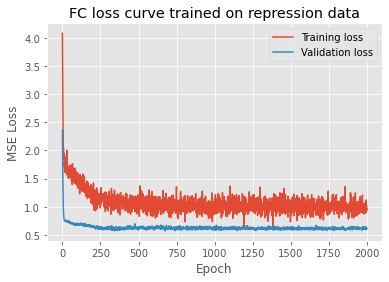

<Figure size 576x432 with 0 Axes>

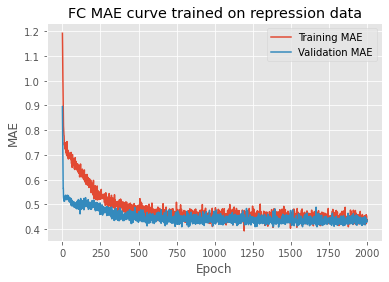

<Figure size 864x864 with 0 Axes>

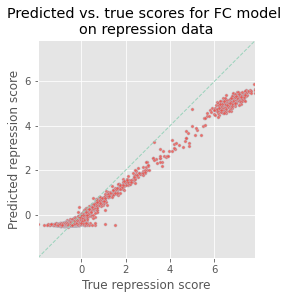

<Figure size 864x864 with 0 Axes>

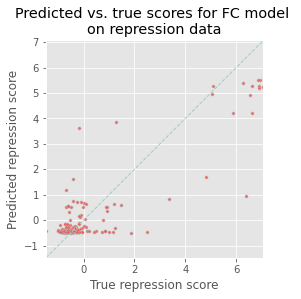

<Figure size 864x864 with 0 Axes>

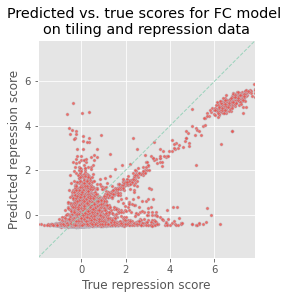

<Figure size 864x864 with 0 Axes>

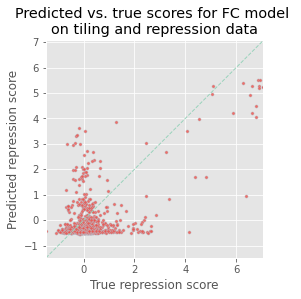

<Figure size 864x864 with 0 Axes>

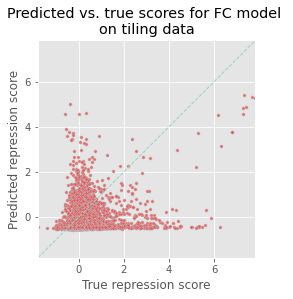

<Figure size 864x864 with 0 Axes>

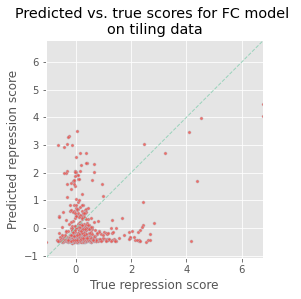

[[-0.39376372]
 [-0.4290388 ]
 [-0.36200115]
 ...
 [-0.4305869 ]
 [-0.41938415]
 [-0.34591064]]
9/9 [==============================] - 0s 2ms/step - loss: 0.9520 - mean_squared_error: 0.6042 - mean_absolute_error: 0.4295
Validation MSE (Repressor Data): [0.9520057439804077, 0.6042264103889465, 0.42949140071868896]
25/25 [==============================] - 0s 2ms/step - loss: 1.2086 - mean_squared_error: 0.8608 - mean_absolute_error: 0.6976
Validation MSE (Tiling Data): [1.2086092233657837, 0.8608298897743225, 0.6976003050804138]


In [9]:
initializer = tf.initializers.VarianceScaling(scale=2.0)
regu1 = tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-4)
dataOrder = ['repr', 'comb', 'tiling'] #Training order between combined data, repression, and tiiliing

layers = [
    tf.keras.layers.Input(shape=(1900,)),
    tf.keras.layers.Dense(900, activation='relu',
                          kernel_initializer=initializer, kernel_regularizer=regu1),
    tf.keras.layers.Dropout(0.4),
          tf.keras.layers.Dense(300, activation='relu',
                          kernel_initializer=initializer, kernel_regularizer=regu1),
    tf.keras.layers.Dropout(0.4),
          tf.keras.layers.Dense(100, activation='relu',
                          kernel_initializer=initializer, kernel_regularizer=regu1),
    tf.keras.layers.Dropout(0.4),
          tf.keras.layers.Dense(1,
                          kernel_initializer=initializer),
    tf.keras.layers.Dropout(0.2),
]

model = tf.keras.Sequential(layers)
print(model.summary())

n_epochs = 2000
learning_rates = [3.1622e-5]

for lr in learning_rates:
    
    out, val_mse = modelTrain(model, lr, n_epochs, batch_size=128, data = dataOrder[0])
    
    plot(out, data = dataOrder[0])
    plotPred(model, data = dataOrder[0], model_type="FC")
    plotPred(model, data = dataOrder[1], model_type="FC")
    plotPred(model, data = dataOrder[2], model_type="FC")
    
    print(model.predict(x_train_til))
    
    print('Validation MSE (Repressor Data):', model.evaluate(x_val_repr, y_val_repr))
    print('Validation MSE (Tiling Data):', model.evaluate(x_val_til, y_val_til))
    
    

8/8 [==============================] - 0s 3ms/step - loss: 1.1321 - mean_squared_error: 0.7843 - mean_absolute_error: 0.4982
test mse [1.1320700645446777, 0.7842908501625061, 0.498172402381897]


<Figure size 864x864 with 0 Axes>

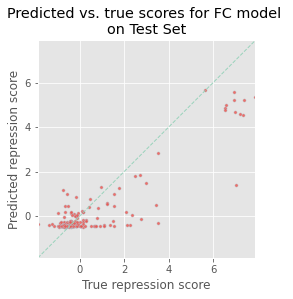

In [10]:
print("Pfam Test Loss, MSE, MAE",  model.evaluate(x_test_repr, y_test_repr))
test_pred = model.predict(x_test_repr)
updated_plots.plotActualVsPred(y_test_repr, test_pred, label="repression score", 
                                   title='Predicted vs. true scores for ' + 'FC' + ' model \non ' + 'Test Set (Pfam)',
                                    show_title=True, show=True, save=True)


In [ ]:
print("Tiling Test Loss, MSE, MAE",  model.evaluate(x_test_til, y_test_til))
test_pred = model.predict(x_test_til)
updated_plots.plotActualVsPred(y_test_til, test_pred, label="repression score", 
                                   title='Predicted vs. true scores for ' + 'FC' + ' model \non ' + 'Test Set (Tiling)',
                                    show_title=True, show=True, save=True)

43/43 [==============================] - 0s 3ms/step - loss: 0.6211 - mean_squared_error: 0.4537 - mean_absolute_error: 0.3984
test mse [0.6210916042327881, 0.45366257429122925, 0.39844274520874023]


<Figure size 864x864 with 0 Axes>

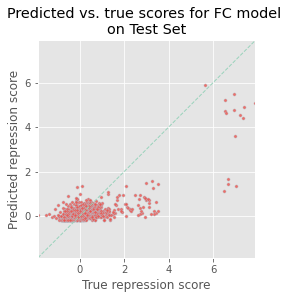

In [11]:
print("Combined Test Loss, MSE, MAE",  model.evaluate(x_test_comb, y_test_comb))
test_pred = model.predict(x_test_comb)
updated_plots.plotActualVsPred(y_test_comb, test_pred, label="repression score", 
                                   title='Predicted vs. true scores for ' + 'FC' + ' model \non ' + 'Test Set (Combined)',
                                    show_title=True, show=True, save=True)

## 2. Proteome Analysis

In [77]:
full_data = np.concatenate((x_train_til, x_val_til, x_test_til), axis = 0)
N = len(full_data)
dist = pairwise_distances(full_data) + 10000*np.eye(N)

0.13630290227785768

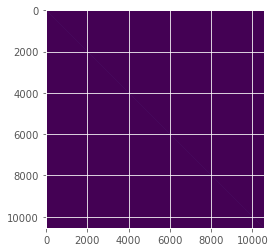

In [78]:
plt.imshow(dist)
np.min(dist)

In [ ]:
full_data = np.concatenate((x_train_repr, x_val_repr, x_test_repr), axis = 0)
N = len(full_data)
dist = pairwise_distances(full_data) + 10000*np.eye(N)

In [ ]:
plt.imshow(dist)
np.min(dist)

In [63]:
full_data = np.concatenate((x_train_comb, x_val_comb, x_test_comb), axis = 0)

In [79]:
hg_df = pd.DataFrame()
thresh = -1

for hg_file in range(21):
    print('File Number:', hg_file)
    hg_test = pd.read_csv("/data/UniRep1900_TiledProteome_" + str(hg_file) + ".csv", index_col=0)
    
    print('Total Tiles:',len(hg_test))
    hg_test_array = np.array(hg_test[["avg_UniRep_" + str(i) for i in range(1900)]])
    min_dist = np.min(pairwise_distances(hg_test_array, full_data), axis = 1)
    keep_idx = min_dist >= thresh
    hg_pred = model.predict(hg_test_array[keep_idx])
    
    print('Remaining Tiles:',len(hg_pred))
    hg_test = hg_test[keep_idx]
    hg_test["fc_pred_repr"] = hg_pred
    hg_df = hg_df.append(hg_test[["id", "sequence", "fc_pred_repr"]])

    print('Tiles so far:',len(hg_df),'\n')

hg_df.head()

File Number: 0
Total Tiles: 12533
Remaining Tiles: 12415
Tiles so far: 12415 

File Number: 1
Total Tiles: 12533
Remaining Tiles: 12466
Tiles so far: 24881 

File Number: 2
Total Tiles: 12533
Remaining Tiles: 12412
Tiles so far: 37293 

File Number: 3
Total Tiles: 12533
Remaining Tiles: 12441
Tiles so far: 49734 

File Number: 4
Total Tiles: 12533
Remaining Tiles: 12362
Tiles so far: 62096 

File Number: 5
Total Tiles: 12533
Remaining Tiles: 12428
Tiles so far: 74524 

File Number: 6
Total Tiles: 12533
Remaining Tiles: 12433
Tiles so far: 86957 

File Number: 7
Total Tiles: 12533
Remaining Tiles: 12393
Tiles so far: 99350 

File Number: 8
Total Tiles: 12533
Remaining Tiles: 12367
Tiles so far: 111717 

File Number: 9
Total Tiles: 12533
Remaining Tiles: 12411
Tiles so far: 124128 

File Number: 10
Total Tiles: 12533
Remaining Tiles: 12376
Tiles so far: 136504 

File Number: 11
Total Tiles: 12533
Remaining Tiles: 12469
Tiles so far: 148973 

File Number: 12
Total Tiles: 12533
Remaining T

,id,sequence,fc_pred_repr
0,ENST00000367772.8_0_80,MGSENSALKSYTLREPPFTLPSGLAVYPAVLQDGKFASVFVYKREN...,0.599078
1,ENST00000367772.8_160_240,QSIRDPASIPPEEMSPEFTTLPECHGHARDAFSFGTLVESLLTILN...,-0.102750
2,ENST00000367772.8_280_360,LSEELIASRLVPLLLNQLVFAEPVAVKSFLPYLLGPKKDHAQGETP...,0.043473
3,ENST00000367772.8_320_400,AQGETPCLLSPALFQSRVIPVLLQLFEVHEEHVRMVLLSHIEAYVE...,0.009952
4,ENST00000367772.8_480_560,QRDYYNTLLQTGDPFSQPIKFPINGLSDVKNTSEDSENFPSSSKKS...,0.217219


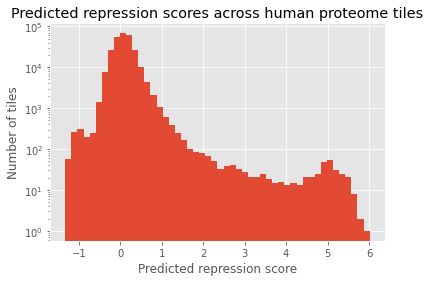

294
263193
259525


In [71]:
plt.hist(hg_df.fc_pred_repr, bins=50, log=True)
plt.title("Predicted repression scores across all human proteome tiles")
plt.xlabel("Predicted repression score")
plt.ylabel("Number of tiles")
plt.savefig("predicted_full_proteome_hist.jpeg")
plt.show()
print(len(hg_df[(hg_df.fc_pred_repr > 4)]))
print(len(hg_df))
print(len(set(hg_df.fc_pred_repr)))

In [79]:
hg_df = pd.DataFrame()
thresh = 0.15

for hg_file in range(21):
    print('File Number:', hg_file)
    hg_test = pd.read_csv("/data/UniRep1900_TiledProteome_" + str(hg_file) + ".csv", index_col=0)
    
    print('Total Tiles:',len(hg_test))
    hg_test_array = np.array(hg_test[["avg_UniRep_" + str(i) for i in range(1900)]])
    min_dist = np.min(pairwise_distances(hg_test_array, full_data), axis = 1)
    keep_idx = min_dist >= thresh
    hg_pred = model.predict(hg_test_array[keep_idx])
    
    print('Remaining Tiles:',len(hg_pred))
    hg_test = hg_test[keep_idx]
    hg_test["fc_pred_repr"] = hg_pred
    hg_df = hg_df.append(hg_test[["id", "sequence", "fc_pred_repr"]])

    print('Tiles so far:',len(hg_df),'\n')

hg_df.head()

File Number: 0
Total Tiles: 12533
Remaining Tiles: 12415
Tiles so far: 12415 

File Number: 1
Total Tiles: 12533
Remaining Tiles: 12466
Tiles so far: 24881 

File Number: 2
Total Tiles: 12533
Remaining Tiles: 12412
Tiles so far: 37293 

File Number: 3
Total Tiles: 12533
Remaining Tiles: 12441
Tiles so far: 49734 

File Number: 4
Total Tiles: 12533
Remaining Tiles: 12362
Tiles so far: 62096 

File Number: 5
Total Tiles: 12533
Remaining Tiles: 12428
Tiles so far: 74524 

File Number: 6
Total Tiles: 12533
Remaining Tiles: 12433
Tiles so far: 86957 

File Number: 7
Total Tiles: 12533
Remaining Tiles: 12393
Tiles so far: 99350 

File Number: 8
Total Tiles: 12533
Remaining Tiles: 12367
Tiles so far: 111717 

File Number: 9
Total Tiles: 12533
Remaining Tiles: 12411
Tiles so far: 124128 

File Number: 10
Total Tiles: 12533
Remaining Tiles: 12376
Tiles so far: 136504 

File Number: 11
Total Tiles: 12533
Remaining Tiles: 12469
Tiles so far: 148973 

File Number: 12
Total Tiles: 12533
Remaining T

,id,sequence,fc_pred_repr
0,ENST00000367772.8_0_80,MGSENSALKSYTLREPPFTLPSGLAVYPAVLQDGKFASVFVYKREN...,0.599078
1,ENST00000367772.8_160_240,QSIRDPASIPPEEMSPEFTTLPECHGHARDAFSFGTLVESLLTILN...,-0.102750
2,ENST00000367772.8_280_360,LSEELIASRLVPLLLNQLVFAEPVAVKSFLPYLLGPKKDHAQGETP...,0.043473
3,ENST00000367772.8_320_400,AQGETPCLLSPALFQSRVIPVLLQLFEVHEEHVRMVLLSHIEAYVE...,0.009952
4,ENST00000367772.8_480_560,QRDYYNTLLQTGDPFSQPIKFPINGLSDVKNTSEDSENFPSSSKKS...,0.217219


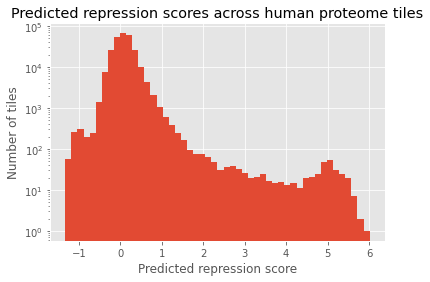

286
260804
257169


In [80]:
plt.hist(hg_df.fc_pred_repr, bins=50, log=True)
plt.title("Predicted repression scores across unseen human proteome tiles")
plt.xlabel("Predicted repression score")
plt.ylabel("Number of tiles")
plt.savefig("predicted_new_proteome_hist.jpeg")
plt.show()
print(len(hg_df[(hg_df.fc_pred_repr > 4)]))
print(len(hg_df))
print(len(set(hg_df.fc_pred_repr)))

In [81]:
thresh = 4 #Threshold repression for tiles to be analyzed in Panther
sorted_hg_df = hg_df.sort_values("fc_pred_repr", axis=0, ascending=False)
out = open("new_panther_input.txt", "w+")
for i in range(len(sorted_hg_df[(sorted_hg_df["fc_pred_repr"] > thresh)])):
    out.write(sorted_hg_df[(sorted_hg_df["fc_pred_repr"] > thresh)].iloc[i]["id"].split("_")[0])
    out.write("\n")
out.close()

print(sorted_hg_df.head())
print(sorted_hg_df.tail())

                             id  \
97881   ENST00000300870.15_0_80   
193618   ENST00000419098.6_0_80   
194948   ENST00000510175.6_0_80   
205035   ENST00000315475.7_0_80   
134940   ENST00000594901.1_0_80   

                                                 sequence  fc_pred_repr  
97881   MGLLTFRDVAVEFSLEEWEHLEPAQKNLYQDVMLENYRNLVSLGLV...      6.013600  
193618  MELLTFRDVAIEFSPEEWKCLDPAQQNLYRDVMLENYRNLISLGVA...      5.822792  
194948  MELLTFKDVAIEFSPEEWKCLDTSQQNLYRDVMLENYRNLVSLGVS...      5.791427  
205035  MAVDLLSAQEPVTFRDVAVFFSQDEWLHLDSAQRALYREVMLENYS...      5.700659  
134940  MAVVATLRLSAQGTVTFEDVAVKFTQEEWNLLSEAQRCLYRDVTLE...      5.642412  
                                  id  \
149585     ENST00000304636.7_440_520   
19931    ENST00000370571.7_1000_1080   
238869  ENST00000303045.11_1280_1360   
183603  ENST00000358511.10_1440_1520   
218816   ENST00000341947.6_1120_1200   

                                                 sequence  fc_pred_repr  
149585  GEPGPRGERGEAGIPGVPGAKG

In [15]:
hg_df.to_csv("human_proteome_predictions.csv", header=True, index=False)

## 3. Conv Model

In [27]:
ALPHABET = 'GALMFWKQESPVICYHRNDT'

In [28]:
def onehot_encode(aaseq: str):
    """
    Convert AA sequence to onehot encoding numpy array.
    Args:
        aaseq - str
    Returns:
        onehotarr - (lenseq, 20) np.array
    """
    alphabet = 'GALMFWKQESPVICYHRNDT'
    aa2int = {k: i for i,k in enumerate(alphabet)}
    #int2aa = {i: k for i,k in enumerate(alphabet)}

    lenseq = len(aaseq)
    onehotarr = np.zeros((lenseq, 20), dtype=int)
    for i,aa in enumerate(aaseq):
        onehotarr[i, aa2int[aa]] = 1

    return onehotarr

In [29]:
def translate(seq):
    table = { 
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M', 
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T', 
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K', 
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                  
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L', 
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P', 
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q', 
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R', 
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V', 
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A', 
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E', 
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G', 
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S', 
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L', 
        'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_', 
        'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W',
        'NNG':'C'
    } 
    protein ="" 
    if len(seq)%3 == 0: 
        for i in range(0, len(seq), 3): 
            codon = seq[i:i + 3]
            aa = table[codon]
            if aa == '_':
                break
            protein+= table[codon] 
    return protein

In [30]:
oh = lambda x: onehot_encode(x["Extended Domain sequence"])
# test = onehot_encode(nucrepr_data.loc[1,"Extended Domain sequence"])

nucrepr_data = pd.read_csv("./data/NucRepr_data.csv")
nucrepr_data["one_hot_encoding"] = nucrepr_data["Extended Domain sequence"].apply(onehot_encode)


# Each sample should have an 80 AA sequence; let's make sure that's the case
act = np.sum(nucrepr_data["one_hot_encoding"].apply(np.sum))
exp = len(nucrepr_data["one_hot_encoding"])*80
print("Expected:", exp)
print("Actual:", act)

Expected: 429520
Actual: 429519


In [31]:
# Show samples with AA sequence length < 80
nucrepr_data[nucrepr_data["one_hot_encoding"].apply(np.sum)<80]

,Gene entry name,Domain ID,label,R1 ReprD5,countsOFF_R1 ReprD5,countsON_R1 ReprD5,R2 ReprD5,countsOFF_R2 ReprD5,countsON_R2 ReprD5,Avg ReprD5,...,Hit,Well-expressed,Category,Domain start,Domain length,Pfam Domain sequence,Extended Domain sequence,Extended Domain DNA sequence,Genes that contain the same extended domain sequence,one_hot_encoding
24,ADIG_HUMAN,Adipogenin,Short_nuclear_domain;ADIG_HUMAN;Adipogenin;1;77,-0.237776,2433,2830,-0.133883,2597,2900,-0.18583,...,False,False,Short nuclear domain,1,77.0,MKYPLMPLVNDLTFSFLVFWFCLPVGLLLLLIIWLRFLLSQDSEEN...,KYPLMPLVNDLTFSFLVFWFCLPVGLLLLLIIWLRFLLSQDSEEND...,AAGTACCCCCTGATGCCCCTGGTGAACGACCTGACCTTCAGCTTCC...,NaN,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [32]:
loader = data_loader.DataLoader("./data/UniRep1900_BareNucRepr.csv")
id_train, id_val, id_test = loader.getIdx()

n_train_repr = len(id_train)
n_val_repr = len(id_val)
n_test_repr = len(id_test)
n_seq = 80
n_AA = 20

_, (y_train_repr, y_val_repr, y_test_repr) = loader.loadTrainValTest()

nuc_csv = pd.read_csv("./data/UniRep1900_BareNucRepr.csv")
nuc_csv["one_hot_encoding"] = nuc_csv["Extended Domain sequence"].apply(onehot_encode)

x_train_repr = np.zeros((n_train_repr, 1, n_seq, n_AA))
for i in range(n_train_repr):
    x_train_repr[i,0,:,:] = nuc_csv.loc[id_train[i],"one_hot_encoding"]
    
x_val_repr = np.zeros((n_val_repr, 1, n_seq, n_AA))
for i in range(n_val_repr):
    x_val_repr[i,0,:,:] = nuc_csv.loc[id_val[i],"one_hot_encoding"]

x_test_repr = np.zeros((n_test_repr, 1, n_seq, n_AA))
for i in range(n_test_repr):
    x_test_repr[i,0,:,:] = nuc_csv.loc[id_test[i],"one_hot_encoding"]


print(x_train_repr.shape)
print(x_val_repr.shape)
print(x_test_repr.shape)

(2792, 1, 80, 20)
(262, 1, 80, 20)
(239, 1, 80, 20)


In [33]:
loader = data_loader.DataLoader("./data/UniRep1900_BareTilingRepressors.csv")
id_train, id_val, id_test = loader.getIdx()

n_train_til = len(id_train)
n_val_til = len(id_val)
n_test_til = len(id_test)
n_seq = 80
n_AA = 20

_, (y_train_til, y_val_til, y_test_til) = loader.loadTrainValTest()

nuc_csv = pd.read_csv("./data/UniRep1900_BareTilingRepressors.csv")
nuc_csv["aa"] = nuc_csv["Sequence"].apply(translate)
#nuc_csv.to_csv("AA_UniRep1900_BareTilingRepressors.csv")
nuc_csv["one_hot_encoding"] = nuc_csv["aa"].apply(onehot_encode)

# Next
x_train_til = np.zeros((n_train_til,1, n_seq, n_AA))
for i in range(n_train_til):
    x_train_til[i,0,:,:] = nuc_csv.loc[id_train[i],"one_hot_encoding"]
    
x_val_til = np.zeros((n_val_til, 1, n_seq, n_AA))
for i in range(n_val_til):
    x_val_til[i,0,:,:] = nuc_csv.loc[id_val[i],"one_hot_encoding"]

x_test_til = np.zeros((n_test_til, 1, n_seq, n_AA))
for i in range(n_test_til):
    x_test_til[i,0,:,:] = nuc_csv.loc[id_test[i],"one_hot_encoding"]



# Each sample should have an 80 AA sequence; let's make sure that's the case
act = np.sum(nuc_csv["one_hot_encoding"].apply(np.sum))
exp = len(nuc_csv["one_hot_encoding"])*80
print("Expected:", exp)
print("Actual:", act)
    
print(x_train_til.shape)
print(x_val_til.shape)
print(x_test_til.shape)

Expected: 843040
Actual: 843040
(8613, 1, 80, 20)
(790, 1, 80, 20)
(1135, 1, 80, 20)


In [34]:
# Combine features
x_train_comb = np.append(x_train_repr, x_train_til, axis = 0)
x_val_comb = np.append(x_val_repr, x_val_til, axis = 0)
x_test_comb = np.append(x_test_repr, x_test_til, axis = 0)

# Combine labels
y_train_comb = np.append(y_train_repr, y_train_til, axis = 0)
y_val_comb = np.append(y_val_repr, y_val_til, axis = 0)
y_test_comb = np.append(y_test_repr, y_test_til, axis = 0)


# Define random permutation
train_ord = np.arange(len(x_train_comb))
np.random.shuffle(train_ord)

val_ord = np.arange(len(x_val_comb))
np.random.shuffle(val_ord)

test_ord = np.arange(len(x_test_comb))
np.random.shuffle(test_ord)


# Shuffle features and labels
x_train_comb = x_train_comb[train_ord,:]
x_val_comb = x_val_comb[val_ord,:]
x_test_comb = x_test_comb[test_ord,:]

y_train_comb = y_train_comb[train_ord]
y_val_comb = y_val_comb[val_ord]
y_test_comb = y_test_comb[test_ord]

print("Train Size (Repression, Tiling, Combined)")
print(len(x_train_repr))
print(len(x_train_til))
print(len(x_train_comb))

print("\nValidation Size (Repression, Tiling, Combined)")
print(len(x_val_repr))
print(len(x_val_til))
print(len(x_val_comb))

print("\nTest Size (Repression, Tiling, Combined)")
print(len(x_test_repr))
print(len(x_test_til))
print(len(x_test_comb))

Train Size (Repression, Tiling, Combined)
2792
8613
11405

Validation Size (Repression, Tiling, Combined)
262
790
1052

Test Size (Repression, Tiling, Combined)
239
1135
1374


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 80, 40)         32040     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 80, 24)         38424     
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 80, 24)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 40, 24)         0         
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 961       
Total params: 71,425
Trainable params: 71,425
Non-trainable params: 0
__________________________________________________

<Figure size 576x432 with 0 Axes>

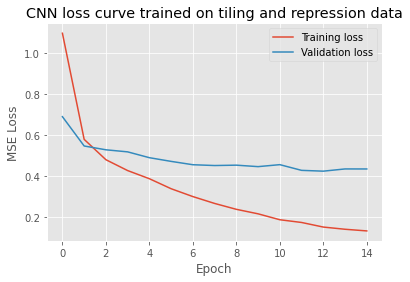

<Figure size 576x432 with 0 Axes>

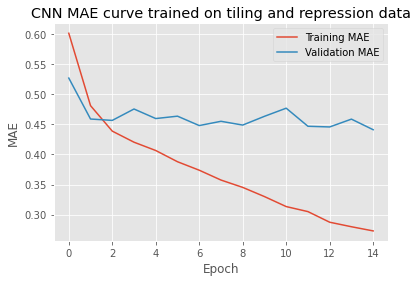

<Figure size 864x864 with 0 Axes>

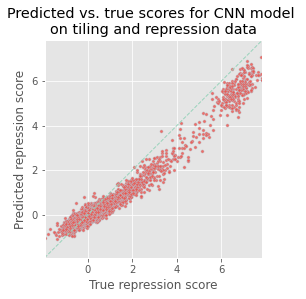

<Figure size 864x864 with 0 Axes>

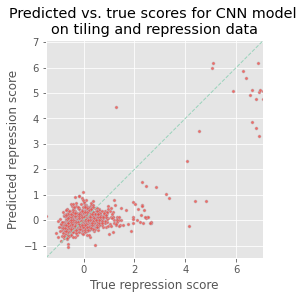

<Figure size 864x864 with 0 Axes>

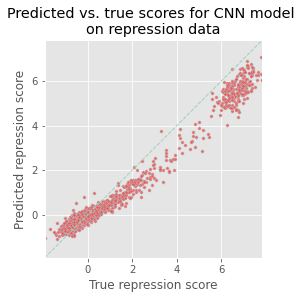

<Figure size 864x864 with 0 Axes>

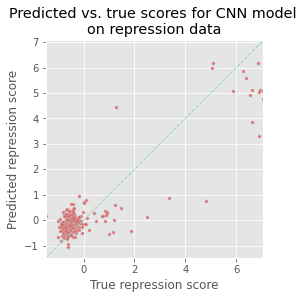

<Figure size 864x864 with 0 Axes>

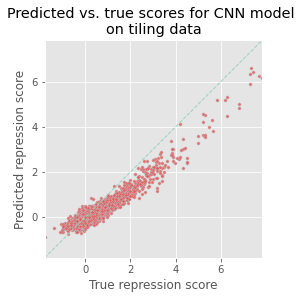

<Figure size 864x864 with 0 Axes>

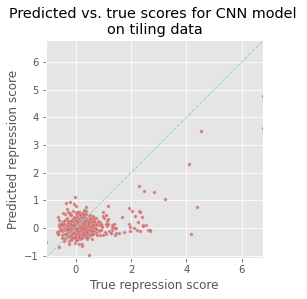

[[ 0.16418038]
 [ 0.31530142]
 [ 0.14891785]
 ...
 [ 0.01295796]
 [-0.0126383 ]
 [-0.08959275]]
9/9 [==============================] - 0s 2ms/step - loss: 0.6180 - mean_squared_error: 0.6180 - mean_absolute_error: 0.5677
Validation MSE (Repressor Data): [0.6180427074432373, 0.6180427074432373, 0.5676807165145874]
25/25 [==============================] - 0s 2ms/step - loss: 0.3742 - mean_squared_error: 0.3742 - mean_absolute_error: 0.3990
Validation MSE (Tiling Data): [0.374223530292511, 0.374223530292511, 0.39895811676979065]


In [35]:
model_type = 'CNN'
dataOrder = ['comb', 'repr', 'tiling']
input_shape = (1, 80, 20)


settings = {'NumConvLayer': 2, 'NumFilter': (40, 24), 'DropOut': 0.4, 'Patience': 2}
input_shape = (1, 80, 20)

initializer = tf.initializers.VarianceScaling(scale=2.0)
layers = [
    tf.keras.layers.Conv2D(settings['NumFilter'][0], (1,40), activation='relu', padding = 'same',
                                kernel_initializer=initializer, input_shape = input_shape),
    tf.keras.layers.Conv2D(settings['NumFilter'][1], (1,40), activation='relu', padding = 'same',
                                kernel_initializer=initializer, input_shape = input_shape),
    tf.keras.layers.Dropout(settings['DropOut']),
    tf.keras.layers.MaxPool2D(pool_size = (1,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, kernel_initializer=initializer),
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(
  monitor='val_mean_squared_error', min_delta=0.0001, patience=settings['Patience'])

model = tf.keras.Sequential(layers)
print(model.summary())

n_epochs = 50
val_losses = []
learning_rates = [5e-4]
for lr in learning_rates:
    print(lr)
    out, val_mse = modelTrain(model, lr, n_epochs, batch_size=128, data = dataOrder[0], 
                              earlystop_callback = [earlystop_callback])
    
    plot(out, data = dataOrder[0], model_type=model_type)
    plotPred(model, data = dataOrder[0], model_type=model_type)
    plotPred(model, data = dataOrder[1], model_type=model_type)
    plotPred(model, data = dataOrder[2], model_type=model_type)
    
    print(model.predict(x_train_til))
    
    print('Validation MSE (Repressor Data):', model.evaluate(x_val_repr, y_val_repr))
    print('Validation MSE (Tiling Data):', model.evaluate(x_val_til, y_val_til))

43/43 [==============================] - 0s 3ms/step - loss: 0.4656 - mean_squared_error: 0.4656 - mean_absolute_error: 0.4515
test mse [0.4656101167201996, 0.4656101167201996, 0.45154279470443726]


<Figure size 864x864 with 0 Axes>

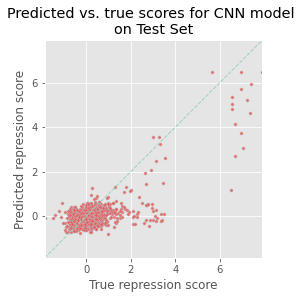

In [37]:
print("test mse",  model.evaluate(x_test_comb, y_test_comb))
test_pred = model.predict(x_test_comb)
updated_plots.plotActualVsPred(y_test_comb, test_pred, label="repression score", 
                                   title='Predicted vs. true scores for ' + 'CNN' + ' model \non ' + 'Test Set (Combined)',
                                    show_title=True, show=True, save=True)